<a href="https://colab.research.google.com/github/ahmettalhasen/Text-Similarity-LDA/blob/master/projectSupportWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer 
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
from gensim.models.coherencemodel import CoherenceModel
!pip install pyLDAvis #Visualize the topics of LDA model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Importing the dataset
df = pd.read_csv('gdrive/My Drive/summer2019/cleanData.csv')

In [0]:
df['tokenized'] = [[word for word in line.split(',') if len(word) > 1] for line in df['words']]
df = df.drop(columns = ['question', 'details', 'quest_len', 'words'])

In [0]:
df

In [6]:
#Using FreqDist
words = [word for row in list(df.tokenized) for word in row]

freqDist = FreqDist(words)
print("Number of distinct words is, ", len(freqDist))

Number of distinct words is,  90064


In [26]:
#Top 30 used words
k = 10000
top_k_words = freqDist.most_common(k)
top_k_words[:500]

[('form', 374032),
 ('email', 83537),
 ('use', 72146),
 ('field', 64265),
 ('submiss', 57746),
 ('work', 53875),
 ('account', 50874),
 ('get', 49285),
 ('page', 47885),
 ('creat', 44741),
 ('need', 44534),
 ('jotform', 44295),
 ('submit', 41911),
 ('like', 41874),
 ('one', 41462),
 ('tri', 40205),
 ('help', 39310),
 ('chang', 38200),
 ('want', 37667),
 ('show', 35691),
 ('option', 34397),
 ('user', 32678),
 ('way', 31950),
 ('payment', 30474),
 ('see', 29853),
 ('receiv', 28185),
 ('link', 27770),
 ('button', 27497),
 ('set', 27434),
 ('make', 26594),
 ('time', 26572),
 ('text', 26165),
 ('question', 25992),
 ('name', 25691),
 ('possibl', 24978),
 ('data', 23397),
 ('websit', 23324),
 ('custom', 23117),
 ('address', 22705),
 ('add', 22027),
 ('select', 21711),
 ('new', 21702),
 ('fill', 21618),
 ('send', 21358),
 ('file', 21152),
 ('upload', 21147),
 ('know', 20994),
 ('pdf', 20896),
 ('error', 20673),
 ('look', 20587),
 ('problem', 20322),
 ('code', 19843),
 ('inform', 19294),
 ('inte

In [19]:
#Bottom 30 used words
k = 5000
top_k_words = freqDist.most_common(k)
top_k_words[-100:]

[('beliz', 28),
 ('benin', 28),
 ('bermuda', 28),
 ('burkina', 28),
 ('faso', 28),
 ('burundi', 28),
 ('cayman', 28),
 ('coco', 28),
 ('keel', 28),
 ('comoro', 28),
 ('djibouti', 28),
 ('dominica', 28),
 ('equatori', 28),
 ('eritrea', 28),
 ('fiji', 28),
 ('polynesia', 28),
 ('greenland', 28),
 ('grenada', 28),
 ('guernsey', 28),
 ('bissau', 28),
 ('kiribati', 28),
 ('kosovo', 28),
 ('kyrgyzstan', 28),
 ('latvia', 28),
 ('lesotho', 28),
 ('libya', 28),
 ('liechtenstein', 28),
 ('madagascar', 28),
 ('malta', 28),
 ('mauritiu', 28),
 ('mayott', 28),
 ('micronesia', 28),
 ('moldova', 28),
 ('montenegro', 28),
 ('morocco', 28),
 ('mozambiqu', 28),
 ('nagorno', 28),
 ('karabakh', 28),
 ('nauru', 28),
 ('antil', 28),
 ('caledonia', 28),
 ('niue', 28),
 ('paraguay', 28),
 ('pitcairn', 28),
 ('emir', 28),
 ('pump', 28),
 ('staf', 28),
 ('erica', 28),
 ('incas', 28),
 ('stabil', 28),
 ('cosmet', 28),
 ('jona', 28),
 ('hop', 28),
 ('templet', 28),
 ('dale', 28),
 ('loggin', 28),
 ('intervent', 2

In [0]:
top_k_words,_ = zip(*freqDist.most_common(k))
top_k_words = set(top_k_words)
#Throws all the rare used words away
def keep_top_k_words(text):
  
    return [word for word in text if word in top_k_words]

df['tokenized'] = df['tokenized'].apply(keep_top_k_words)


In [0]:
df = df.reset_index(drop=True)

In [0]:
df['quest_len'] = df['tokenized'].apply(lambda x: len(x))
quest_lengths = list(df['quest_len'])

MIN_TOKEN_NUMBER = 4

# Histogram Plot
fig, ax = plt.subplots(figsize=(16,8));
n, bins, patches = ax.hist(quest_lengths, 750)
ax.set_xlabel('Question Length (tokens)', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.grid()
plt.xlim(0,150)
ax.grid()
fig.tight_layout()
plt.show()

df = df[df['quest_len'] > MIN_TOKEN_NUMBER]

In [0]:
df = df.reset_index(drop=True)

In [0]:
# question length
df.drop(labels='quest_len', axis=1, inplace=True)

print("length of list:",len(quest_lengths),
      "\naverage question length", np.average(quest_lengths),
      "\nminimum question length", min(quest_lengths),
      "\nmaximum question length", max(quest_lengths))

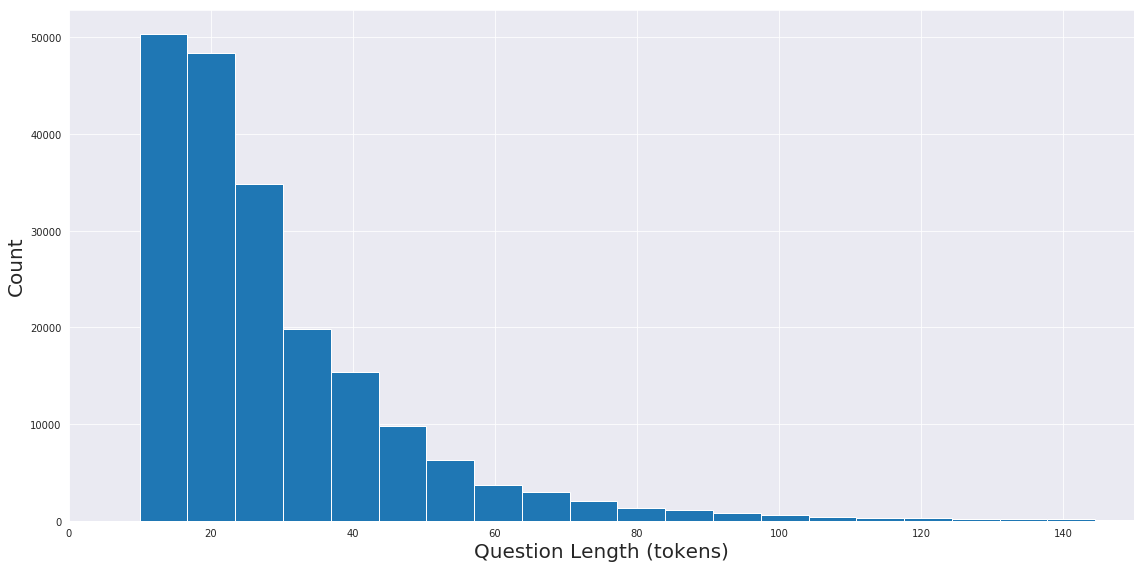

In [0]:
#Splitting into train and test sets.
chosen = np.random.rand(len(df)) < 0.9999
train_set = df[chosen]
test_set = df[~chosen]
train_set.reset_index(drop=True,inplace=True)
test_set.reset_index(drop=True,inplace=True)

In [0]:
test_set


In [0]:
#Creating corpus an dictionary

dictionary = corpora.Dictionary(data['tokenized'])
corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]

def train_lda(cluster_size, num_passes, data):
    """
    This function trains the LDA model
    We setup parameters like number of topics, number of passes to train the model 
    and train set
    """
    
    time01 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=cluster_size, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, minimum_probability=0.0, passes=num_passes)
    time02 = time.time()
    print("Time to train LDA model on ", len(df), "questions: ", (time02-time01)/60, "min")
    return lda

In [0]:
#Alternatif way of LDA


In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

In [0]:
# Training LDA Model and displaying the characteristic words
num_clusters = 700
lda = train_lda(num_clusters, 15, train_set)

In [0]:

topic_highlights = [('*---------------------------', lda.show_topic(topicid=i, topn=20)) for i in range(num_clusters) ]
topic_highlights

In [0]:
#Evaluation of the number of the topics
import pyLDAvis.gensim

LDAvis_prepared = pyLDAvis.gensim.prepare(lda, corpus, dictionary, mds='mmds')
pyLDAvis.display(LDAvis_prepared)


In [0]:
#Topic Distribution

def calculate_all_documents_distribution(ldaModel):
    """
    This function calculates the topic distributions of the all quesitons in the train set
    """
    docs_topic_dist = np.array([[tup[1] for tup in lst] for lst in ldaModel[corpus]])
    return docs_topic_dist


docs_topic_dist = calculate_all_documents_distribution(lda)
print("Shape of the matrix is ", docs_topic_dist.shape)

In [0]:
#Getting a Question From the Test Set
def random_question_picker(test_set):
    """
    This function picks a random question from test set 
    """
    random_article_index = np.random.randint(len(test_set))
    return random_article_index 
  
def calculate_new_document_distribution(test_set, random_article_index):
    """
    This function calculates the topic distributions of the given question
    """
    new_bow = dictionary.doc2bow(test_set.tokenized[random_article_index])
    print(test_set.quest[random_article_index])
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
    return new_doc_distribution

In [0]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))
  
def cosine_dist(query, matrix):
    """
    This function implements cosine similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    return [gensim.matutils.cossim(query, x) for x in matrix]
  

def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [0]:
def retrieve_similar_questions(test_set, train_set, random_article_index, docs_topic_dist):
    """
    This functions retrives similar questions from the train set
    """
    new_doc_distribution = calculate_new_document_distribution(test_set, random_article_index)
    most_sim_ids = get_most_similar_documents(new_doc_distribution,docs_topic_dist)
    most_similar_df = train_set[train_set.index.isin(most_sim_ids)]
    questList = list(most_similar_df['quest'])
    idList = list(most_similar_df['id'])
    return questList,idList

In [0]:
#Giving it a try
def try_many(number):
    for i in range(number):
      print("The Question Number ", i)
      qList,idList = retrieve_similar_questions(test_set, train_set, i, docs_topic_dist)
      a = [print("Similar--> ", el) for el in qList ]

try_many(28)

In [0]:
def get_recommendation_csv(train_set, test_set):
    """
    this function finds recommendation for multiple test data and saving them in a csv file
    """
    dataframe = pd.DataFrame(columns=['id', 'question', 'recommendations', 'idsOfRecommendations'])
    
    for i in range(len(test_set)):
      question_index = i
      qList, idList = retrieve_similar_questions(test_set, train_set, question_index)
      text = ""
      ids = ""
      
      for j in range(len(qList)):
        text = text + "|" + qList[j]
        ids = ids + "," + str(idList[j])
        
      dataframe.loc[i] = [str(test_set['id'][i]), test_set['quest'][i], text, ids]     
      
    ## Saving the latest verison as csv for practical use
    export_csv = dataframe.to_csv('gdrive/My Drive/summer2019/testRecommendations.csv', index = None, header=True)
    print("testRecommendations.csv is created.")

In [0]:
get_recommendation_csv(train_set, test_set)

In [0]:
d = pd.read_csv('gdrive/My Drive/summer2019/testRecommendations.csv')
d.recommendations

In [0]:
ques = []
for row in train_set['tokenized']:
  row = list(dict.fromkeys(row))
  s = ""
  for x in row:
    s = s + " " + x
  s = s.strip()
  ques.append(s)
  
ques

In [0]:
########################


from nltk import ngrams
from scipy.spatial import distance

def similar_question_jaccard(question, train_set):
    """
    This function to finds and returns similar questions among train set 
    by Jaccard Distance
    """
    questions=[]
    for train_quest in train_set:
        dist=distance.jaccard(set(ngrams(question,n=1)),set(ngrams(train_quest,n=1)))
        if(dist<.1):
            questions.append(train_quest)
    return questions

In [0]:
quesTest = ques[:15]
quesTrain = ques[15:]

for q in quesTest:
  print("The Question --------> ", q)
  qs = similar_question_jaccard(q,quesTrain)
  v = [print("Similar ---> ", s) for s in qs]

In [0]:
randNum = random_question_picker(test_set)
test_set.quest[randNum]
qs = similar_question_jaccard(test_set.tokenized[randNum])
qs

In [0]:
#word2Vec
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=40, workers=4)
#TSNE


def tsne_plot(model,title='None'):
    """
    This function creates and TSNE model and plots it
    """
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=80, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 12)) 
    plt.title(title)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


tsne_plot(lda,'Questions')

In [0]:
#Now, We will analyze the goodness of our model based on number of clusters by using coherence value
def compute_coherence_values(train_set, stop=100, start=20, step=10):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    timeCohSt = time.time()
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, stop, step):
        # generate LDA model
        timeTrain01 = time.time()
        model = train_lda(num_topics, 5, train_set)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=train_set, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        timeTrain02 = time.time()
        print("LDA Model with ", num_topics, " topics trained in ", 
              (timeTrain02-timeTrain01)/60, " min. The coherence value which is ",
              coherencemodel.get_coherence(), " added!") 
    
    timeCohEnd = time.time()
    print("Time to train all LDA models and calculating coherence took  ", (timeCohEnd-timeCohSt)/60, "min")
    return model_list, coherence_values

In [0]:
start,stop,step=30,110,10
model_list, coherence_values = compute_coherence_values(train_set, stop, start, step)

# Show graph
plt.plot(range(start, stop, step), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()